In [ ]:
import numpy as np

from utils import *
from generate_data import * 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

from network import *

from plot_data import *
from data_loading import *

import json

from gaussian_predictor_levelsets import *

seed_everything(42)

In [ ]:
seed_everything(42)

class RadiusTransformation2:
    def __init__(self, d, beta=None):
        if beta is None:
            beta = np.random.randn(d)
        self.beta = beta

    def get(self, x):
        return ((( np.linalg.norm(x)) / 2.0 + (np.dot(self.beta, x))**2 / 10) / 2 ) / .5 + 0.15

d = 2
hidden_dim = 5
hidden_dim_matrix = 100
k = 3

tab_coverage = []
tab_warm_start_covariance_coverage = []
tab_warm_start_local_covariance_coverage = []
tab_hyper_rectangle_coverage = []

pert = "exponential"  

n_train = 20_000
n_test = 1_000
n_calibration = 1_000
n_stop = 1_000
n_anchors = 10


config_name = "gau_t"

config_path = "../parameters/" + config_name + ".json"
with open(config_path, 'r') as file : 
    parameters = json.load(file)



hidden_dim = parameters["hidden_dim"]
hidden_dim_matrix = parameters["hidden_dim_matrix"]
n_hidden_layers = parameters["n_hidden_layers"]
n_hidden_layers_matrix = parameters["n_hidden_layers_matrix"]


num_epochs = parameters["num_epochs"]

lr_center = parameters["lr_center"]    
lr_matrix = parameters["lr_matrix"]

batch_size = parameters["batch_size"]

use_lr_scheduler = parameters["use_lr_scheduler"]
keep_best = parameters["keep_best"] 

idx_knowned = np.array(parameters["idx_knowned"])

dtype = torch.float32 if parameters["dtype"] == "float32" else torch.float64

alpha = parameters["alpha"]
print(alpha)

class NonLinearFunction2:
    def __init__(self, d, k, beta=None):
        if beta is None:
            beta = np.random.randn(d, k)
        self.beta = beta
        self.proj  = np.zeros((d, k))
        self.proj[0, 0] = 1.0
        self.proj[1, 1] = 1.0

    def get(self, x):
        nonlinear_term = np.sin(np.dot(x, self.beta)) + 0.5 * np.tanh(np.dot(x**2, self.beta)) + np.dot(x, self.proj)
        return nonlinear_term * 2
    
def generate_cov(n):
    covariance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            covariance_matrix[i, j] = 0.5
            if i == j:
                covariance_matrix[i, j] = 1.0
    return covariance_matrix

cov_matrix = generate_cov(k)

f_star = NonLinearFunction2(d, k)
radius = RadiusTransformation2(d)
local_perturbation = LocalPerturbation(d, k, n_anchors=n_anchors, radius_transformation=radius)
data_generator = DataGenerator(d, k, pert, f_star=f_star, local_perturbation=local_perturbation, covariance_matrix=cov_matrix, bias = False, seed = 42)

x_train, y_train = data_generator.generate(n_train)
x_stop, y_stop = data_generator.generate(n_stop)
x_calibration, y_calibration = data_generator.generate(n_calibration)
x_test, y_test = data_generator.generate(n_test)


x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_stop_tensor = torch.tensor(x_stop, dtype=torch.float32)
y_stop_tensor = torch.tensor(y_stop, dtype=torch.float32)
x_calibration_tensor = torch.tensor(x_calibration, dtype=torch.float32)
y_calibration_tensor = torch.tensor(y_calibration, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



0.1


In [3]:
seed_everything(42)


center_model = Network(d, k, hidden_dim=hidden_dim, n_hidden_layers=n_hidden_layers)
matrix_model = MatrixPredictor(d, k, k, hidden_dim=hidden_dim_matrix) 

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor), batch_size= batch_size, shuffle=True)
stoploader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_stop_tensor, y_stop_tensor), batch_size= batch_size, shuffle=True)
calibrationloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_calibration_tensor, y_calibration_tensor), batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor), batch_size= batch_size, shuffle=True)

gaussian_predictor = GaussianPredictorLevelsets(center_model, matrix_model)

gaussian_predictor.fit(trainloader, 
                        stoploader, 
                        num_epochs = num_epochs,
                        lr_center_models = lr_center,
                        lr_matrix_models = lr_matrix,
                        use_lr_scheduler = use_lr_scheduler,
                        verbose = 1,
                        stop_on_best = keep_best
                        )

Epoch 0: Loss = 5.316748142242432 - Stop Loss = 5.373140811920166 - Best Stop Loss = 5.373140811920166
Epoch 50: Loss = 2.1670479774475098 - Stop Loss = 2.3268799781799316 - Best Stop Loss = 2.3268799781799316
Epoch 100: Loss = 1.9425592422485352 - Stop Loss = 2.0760791301727295 - Best Stop Loss = 2.0760791301727295
Epoch 150: Loss = 1.8619564771652222 - Stop Loss = 2.0475711822509766 - Best Stop Loss = 2.0198726654052734
Epoch 200: Loss = 1.7946418523788452 - Stop Loss = 1.9760704040527344 - Best Stop Loss = 1.9520114660263062
Epoch 250: Loss = 1.7518703937530518 - Stop Loss = 1.9497226476669312 - Best Stop Loss = 1.9093799591064453
Epoch 300: Loss = 1.7134770154953003 - Stop Loss = 1.924412727355957 - Best Stop Loss = 1.9012075662612915
Epoch 350: Loss = 1.697864055633545 - Stop Loss = 1.9118845462799072 - Best Stop Loss = 1.8849910497665405
Epoch 400: Loss = 1.6889270544052124 - Stop Loss = 1.886272668838501 - Best Stop Loss = 1.8829843997955322
Epoch 450: Loss = 1.6855601072311401 

In [4]:
gaussian_predictor.conformalize(x_calibration=x_calibration_tensor, y_calibration=y_calibration_tensor, alpha = alpha)

tensor(2.5600)

In [ ]:
projection_matrix = np.zeros((2, k))
projection_matrix[0, 0] = 1.0
projection_matrix[0, 2] = 1.0
projection_matrix[1, 1] = 1.0


projection_matrix = projection_matrix


projection_matrix_tensor = torch.tensor(projection_matrix, dtype=torch.float32)

In [6]:
idx_knowned = np.array([0])
gaussian_predictor.conformalize_linear_projection(
                                            projection_matrix=projection_matrix_tensor,
                                            x_calibration=x_calibration_tensor, 
                                            y_calibration=y_calibration_tensor, 
                                            alpha = alpha
                                            )

tensor(2.0575)

/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82599/2267364680.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', 5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/z9/c18gf3b53l57gx2mb36lp9vnx5h51x/T/ipykernel_82599/2267364680.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(y_specific_projected_np[:, 0], y_specific_projected_np[:, 1], label=None,

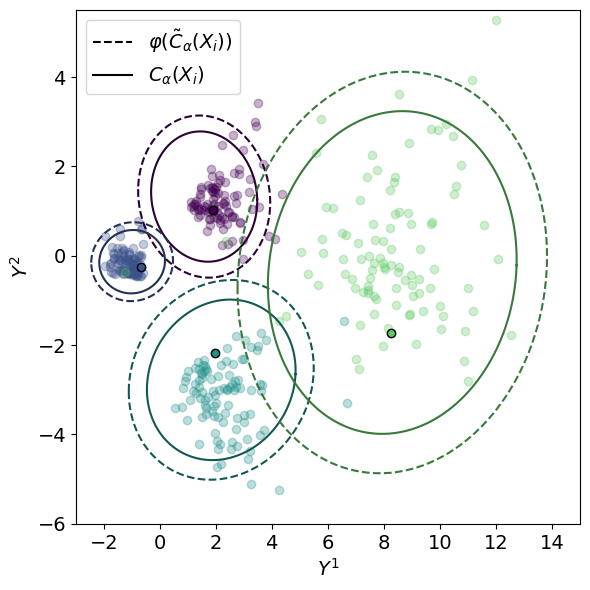

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


tab_seed = [6, 9, 52, 39]
q_val = 2.0
dtype = torch.float32

idx_unknown = np.setdiff1d(np.arange(k), idx_knowned) 

fig, ax = plt.subplots(figsize=(6, 6))

color_map = plt.cm.get_cmap('viridis', 5)
colors = color_map(np.linspace(0, 1, 5))
darker_colors = colors.copy()
from matplotlib.colors import ListedColormap
darker_viridis = ListedColormap(darker_colors)
darker_colors[:, :3] *= 0.6

for i, seed in enumerate(tab_seed): 
        seed_everything(seed)
        x_specific, y_specific = data_generator.generate_specific_x(100)

        x_specific_tensor = torch.tensor(x_specific, dtype=dtype)
        y_specific_tensor = torch.tensor(y_specific, dtype=dtype)

        y_specific_projected = torch.einsum('ik,nk->ni', projection_matrix_tensor, y_specific_tensor)
        y_specific_projected_np = y_specific_projected.detach().numpy()

        centers = gaussian_predictor.get_centers(x_specific_tensor)
        Lambdas_specific = gaussian_predictor.get_Lambdas(x_specific_tensor)

        centers_np = centers.detach().numpy()
        Lambdas_specific_np = Lambdas_specific.detach().numpy()

        centers_projected, Lambdas_projected = get_new_centers_Lambdas_with_linear_projection(centers, Lambdas_specific, projection_matrix_tensor)

        centers_projected_np = centers_projected.detach().numpy()
        Lambdas_projected_np = Lambdas_projected.detach().numpy()

        radius = gaussian_predictor.nu_conformal.item()
        radius_proj = gaussian_predictor.nu_conformal_projection.item()

        ax = add_ellipse(ax,  centers_projected_np[0], Lambdas_projected_np[0], q_val, radius_proj, color = darker_viridis(i), label = None )
                  
        ax.scatter(y_specific_projected_np[:, 0], y_specific_projected_np[:, 1], label=None, c = color_map(i), alpha = 0.3)
        ax.scatter(y_specific_projected_np[0, 0], y_specific_projected_np[0, 1], label=None, c = color_map(i), edgecolors='black', zorder=10)

        ellipse_surface = surface_ellipse_3d(
        centers_np[0], 
        Lambdas_specific_np[0], 
        radius
        )
        
        ellipse_surface_flat = np.array(ellipse_surface).reshape(3, -1)
        projection_matrix_pseudo_inverse = np.linalg.pinv(projection_matrix)
        ellipse_surface_2D = projection_matrix @ ellipse_surface_flat 


        points = ellipse_surface_2D.T
        hull = ConvexHull(points)

        hull_path = np.append(hull.vertices, hull.vertices[0])  # pour fermer l'enveloppe
        plt.plot(points[hull_path, 0], points[hull_path, 1], color=darker_viridis(i), linestyle='--')

ax = add_ellipse(ax,  centers_projected_np[0] + np.array([100, 100]), Lambdas_projected_np[0], q_val, radius, color = "black", linestyle='--', label=fr'$\varphi(\tilde{{C}}_\alpha(X_{{i}}))$')
ax = add_ellipse(ax,  centers_projected_np[0] + np.array([100, 100]), Lambdas_projected_np[0], q_val, radius, color = "black", linestyle='-', label=fr'$C_\alpha(X_{{i}})$')

ax.set_xlabel(r'$Y^1$', fontsize=14)
ax.set_ylabel(r'$Y^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(fontsize=14)
ax.set_xlim(-3, 15)
ax.set_ylim(-6, 5.5)

plt.tight_layout()

plt.savefig(f"../figs/proj_{pert}_level_sets.png", dpi = 300, bbox_inches='tight')
plt.savefig(f"../figs/proj_{pert}_level_sets.pdf", dpi = 300, bbox_inches='tight')

plt.show()

plt.close()